# Backtesting - PB Factor

## Overview:

This project aims to backtest the performance and risks of value-based factor portfolio strategies, specifically, by using the Price to Book Value Per Share matric.


1. Data Transformation
- Creating Stock Availability Tables: Determining which stocks are available for trading at given times using logical conditions and temporal data slicing.
- Weighting Tables: Computing weights for each stock in the portfolio based on P/B ratios.
2. Time series manipulation
- Return Calculation: Resample daily returns to monthly returns using price data. 
3. Portfolio Construction:
- Top and Bottom Quantiles: Stocks are sorted and selected based on their P/B ratios, creating portfolios from the top and bottom segments (e.g., 20%).
- Cumulative Returns: Aggregating monthly returns over time to measure the total performance of portfolios.
4. Statistical Analysis
- Rolling Metrics: Using rolling windows (e.g., 12 months) to calculate ongoing performance metrics, providing a dynamic view of risk and return compared to indexes.
5. Performance Evaluation
- Visualizing Returns: Using matplotlib to draw and compare the cumulative returns of the low and high P/B portfolios vs. index benchmarks.
- Benchmarking: Comparing relative portfolio returns against a benchmark such as an equal-weighted S&P 500 to evaluate relative performance.
6. Sector Analysis
- Concentration Analysis: Examining sector exposures within the portfolios to understand the sectoral distribution influenced by the P/B factor.

In [44]:
import yfinance as yf
import pandas as pd
import requests
import json
import numpy as np
import pickle
import copy
import datetime as dt
import os
import matplotlib.pyplot as plt

data_folder_download = '../datasets/download/'
data_folder_generate = '../datasets/generate/'

## Step 1: Read in all the necessary data files 

In [8]:
with open(data_folder_generate + 'price_df.pkl', 'rb') as f:
    price_df = pickle.load(f)

In [9]:
with open(data_folder_generate + 'sp500_df_v2.0.pkl', 'rb') as f:
    sp500_df = pickle.load(f)

In [17]:
with open(data_folder_generate + 'price_book_value_df_v2.1.pkl', 'rb') as f:
    price_book_value_df = pickle.load(f)

In [18]:
with open(data_folder_generate + 'monthly_availability_df.pkl', 'rb') as f:
    monthly_availability_df = pickle.load(f)

In [196]:
price_book_value_df.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,NaN,NaN,-1.375791,NaN,NaN,15.342422,NaN,2.188069,1.253278,NaN,...,1.114088,1.450599,2.458134,NaN,2.829790,NaN,2.408995,NaN,0.561811,19.318274
2013-04-30,1.477458,NaN,-1.370115,4.396082,NaN,17.485463,NaN,2.295852,1.264960,NaN,...,1.192487,1.432570,2.452921,NaN,2.849299,NaN,2.448387,NaN,0.553493,19.136593
2013-05-31,1.620426,NaN,-1.424434,4.272397,NaN,16.209654,NaN,2.280306,1.220856,7.356389,...,1.077327,1.466470,2.418748,NaN,2.900974,NaN,2.514360,NaN,0.631966,18.545457
2013-06-30,1.528778,NaN,-1.357125,4.257105,1.519978,13.045583,NaN,2.193718,1.249323,6.447033,...,1.061943,1.460106,2.357262,NaN,2.761024,5.173135,2.334045,2.511219,0.604066,15.748677
2013-07-31,1.772261,NaN,-1.599292,3.989762,1.734636,14.483977,NaN,2.313103,1.316394,6.612780,...,1.122273,1.515052,2.467759,NaN,2.555024,5.465300,2.600027,2.669037,0.619105,15.230964


In [197]:
price_book_value_df.loc['2013-06-30': '2013-11-30', 'ICE'] = np.NaN

In [198]:
with open(data_folder_generate + 'price_book_value_df_v2.1.pkl', 'wb') as f: # adjust for the outlier in ICE ticker. 
    pickle.dump(price_book_value_df, f)

In [200]:
stats = price_book_value_df.describe()
stats

,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
count,137.000000,117.000000,138.000000,137.000000,135.000000,138.000000,45.000000,138.000000,138.000000,136.000000,...,138.000000,138.000000,138.000000,81.000000,138.000000,135.000000,138.000000,135.000000,87.000000,138.000000
mean,4.616585,0.864744,-30.310301,3.357674,16.969245,12.430990,18.932848,3.879588,1.374964,7.997945,...,1.757097,1.450661,2.154418,0.796285,5.286227,-0.338934,2.246200,6.039948,0.797866,17.095713
std,2.135751,0.457959,146.947056,1.150400,16.597563,18.521207,9.358354,1.245858,0.289460,0.944632,...,0.412037,0.365561,0.509553,0.223089,1.884803,5.065380,0.391933,2.202739,0.226020,2.760455
min,1.477458,0.192232,-1056.599421,1.041256,1.519978,-44.005036,8.415018,1.976024,0.806691,6.104296,...,1.018900,0.629498,1.167740,0.472158,2.148088,-5.157345,1.650821,2.511219,0.458878,10.648374
25%,2.697243,0.470111,-2.927482,2.503065,3.279695,12.163652,12.297910,2.816762,1.201857,7.379420,...,1.414945,1.277940,1.737931,0.610382,3.578751,-3.918827,1.957337,4.388339,0.612806,15.275301
50%,4.179405,0.800769,-1.639691,3.289761,6.611553,14.668741,14.678856,3.768046,1.337680,7.859131,...,1.758982,1.362608,2.114290,0.705418,5.323870,-3.131313,2.160990,5.862282,0.673738,17.044593
75%,6.437137,1.133096,5.830828,4.141056,34.786430,17.443646,24.470974,4.971874,1.436986,8.479360,...,2.138292,1.527121,2.414617,1.004364,6.510601,5.346501,2.455550,7.238630,0.976413,19.015619
max,10.121089,2.631841,134.392841,5.574478,52.688314,57.980702,46.163790,6.498017,2.170555,12.076048,...,2.419318,2.275617,3.488876,1.362570,10.500655,9.922036,3.415147,12.073498,1.226450,23.911076


## Step 2: Rank price_to_book_value_df

In [13]:
# Remove the negative P/B ratio to only consider low positive P/B as value factors. 
price_book_value_df = price_book_value_df.map(lambda x: np.NaN if x < 0 else x)

# Rank the stocks based on the value of the price/book ratio
price_book_ranking_df = price_book_value_df.rank(axis = 1)

## Step 3: Create monthly availability table for tickers

In [32]:
sp500_df.head()

,Security,GICS Sector,GICS Sub-Industry,Date_Added,Date_Removed,Founded,CIK
Ticker,,,,,,,
A,Agilent Technologies,Health Care,Life Sciences Tools & Services,2000-06-05,NaT,1999,0001090872
AA,Alcoa,Materials,NaN,NaT,2016-11-01,NaN,0001675149
AAL,American Airlines Group,Industrials,Passenger Airlines,2015-03-23,NaT,1934,0000006201
AAP,Advance Auto Parts,Consumer Discretionary,NaN,2015-07-08 00:00:00,2023-08-25,NaN,0001158449
AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",1982-11-30,NaT,1977,0000320193


In [33]:
# set the NaT value under Date_Added and Date_Removed to proper datetime: 
# for example: if a company’s Date_Added is NaT, it means the company existed in the index before 2013, if Date_Removed is NaT, the company is still part of the index.
sp500_df['Date_Added'].fillna(pd.to_datetime('2000-01-01'), inplace=True)
sp500_df['Date_Removed'].fillna(pd.to_datetime('2024-12-31'), inplace=True)
# change ['Date_Added'] to datetime.
sp500_df['Date_Added'] = pd.to_datetime(sp500_df['Date_Added'], format = "%Y-%m-%d") 

In [37]:
# save the updated merged_sp500df_final.pkl file.
with open(data_folder_generate + 'sp500_df_v3.0.pkl', 'wb') as f:
     pickle.dump(sp500_df, f)

In [204]:
# Create a dataframe indicator for the monthly availability of the individual stock within the index.
monthly_availability_df = copy.deepcopy(price_book_ranking_df)

for ticker in sp500_df.index: 
    monthly_availability_df[ticker] = monthly_availability_df.index.to_series().apply(
        lambda date: 1 if ((date < sp500_df.loc[ticker, 'Date_Removed']) & 
                           (date >= sp500_df.loc[ticker, 'Date_Added'])) else np.NaN
    )

In [205]:
monthly_availability_df.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,1,1.0,NaN,NaN,1,1,NaN,1,NaN,1,...,1,1,1.0,1.0,1,1,1,NaN,1.0,NaN
2013-04-30,1,1.0,NaN,NaN,1,1,NaN,1,NaN,1,...,1,1,1.0,1.0,1,1,1,NaN,1.0,NaN
2013-05-31,1,1.0,NaN,NaN,1,1,NaN,1,NaN,1,...,1,1,1.0,1.0,1,1,1,NaN,1.0,NaN
2013-06-30,1,1.0,NaN,NaN,1,1,NaN,1,NaN,1,...,1,1,1.0,1.0,1,1,1,NaN,1.0,1.0
2013-07-31,1,1.0,NaN,NaN,1,1,NaN,1,NaN,1,...,1,1,1.0,1.0,1,1,1,NaN,1.0,1.0


In [206]:
# save the monthly_availability_df.pkl file
with open(data_folder_generate + 'monthly_availability_df.pkl', 'wb') as f:
     pickle.dump(monthly_availability_df, f)

## Step 4: Create monthly weighting table for tickers

In [11]:
def weighting(metric_ranking_df, monthly_availability_df): 
    """
    Calculate the weighting among selected stocks to construct the portfolio for each month
    Select the top 20% and bottom 20% stocks based on ranking and assign equal weights between the stocks. 
    """
    # filter the PB ranking df based on the monthly availability of the stocks.
    filtered_metric_ranking_df = metric_ranking_df*monthly_availability_df

    # Calculating the top and bottom 20% of the companies for each month: 
    top_20_threshold = filtered_metric_ranking_df.quantile(0.8, axis=1)
    bottom_20_threshold = filtered_metric_ranking_df.quantile(0.2, axis=1)

    # Create masks for top 20% and bottom 20%
    top_20_mask = filtered_metric_ranking_df.ge(top_20_threshold, axis=0)
    bottom_20_mask = filtered_metric_ranking_df.le(bottom_20_threshold, axis=0)

    # Filter dataframes for top 20% and bottom 20%
    top_20_df = filtered_metric_ranking_df[top_20_mask]
    bottom_20_df = filtered_metric_ranking_df[bottom_20_mask]

    # Calculate equal weight for each stock in top 20% and bottom 20%
    top_20_weights = 1 / top_20_df.count(axis=1)
    bottom_20_weights = 1 / bottom_20_df.count(axis=1)

    # Apply the weights across the dataframe. 
    top_20_df_weights = top_20_df.map(lambda x: 1 if pd.notna(x) else np.NaN).multiply(top_20_weights, axis=0)
    bottom_20_df_weights = bottom_20_df.map(lambda x: 1 if pd.notna(x) else np.NaN).multiply(bottom_20_weights, axis=0)

    return top_20_df_weights, bottom_20_df_weights

In [19]:
top_20_df_weights, bottom_20_df_weights = weighting(price_book_ranking_df, monthly_availability_df)

## Step 5: Calculate monthly return table for tickers

In [20]:
monthly_returns_df = price_df/price_df.shift(1) - 1
monthly_returns_df = monthly_returns_df.iloc[1:] 

In [21]:
monthly_returns_df.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-30,-0.012628,-0.002347,-0.004125,0.014882,0.000271,0.139681,NaN,0.049260,0.009321,0.083519,...,0.070370,-0.012429,-0.002120,-0.002326,0.006894,-0.048327,0.016352,-0.010185,-0.014806,-0.009405
2013-05-31,0.096766,0.003394,0.039646,-0.028135,0.022419,-0.072964,NaN,-0.006771,-0.034866,0.008226,...,-0.096571,0.023664,-0.013931,0.024475,0.018136,-0.005431,0.026945,-0.021222,0.141779,-0.030890
2013-06-30,-0.056558,-0.080000,-0.065453,-0.003579,-0.118293,-0.031623,NaN,-0.048814,0.003906,-0.123615,...,-0.003769,-0.001327,-0.017619,0.038570,-0.042644,0.023469,-0.042918,-0.048620,0.030281,-0.034688
2013-07-31,0.046071,0.016623,0.178441,0.016262,0.141225,0.110259,NaN,0.054421,0.053686,0.025709,...,0.056811,0.037631,0.046875,0.069459,-0.074610,0.056477,0.113958,0.062845,0.024896,-0.032873
2013-08-31,0.042701,-0.027759,-0.164858,-0.029336,0.083767,-0.063105,NaN,-0.090090,-0.015876,-0.021136,...,-0.067780,-0.063867,-0.020756,0.028866,-0.001374,-0.039769,-0.052587,-0.012346,-0.055026,-0.022140


## Step 6: Calculate cumulative returns for 'top 20%' and 'bottom 20%' portfolios

In [3]:
def cal_cum_rets(top_20_df_weights, bottom_20_df_weights, monthly_returns_df): 
    
    value_20130331 = 100
    # Multiply the monthly returns by the equal weights and aggregate monthly returns. 
    top_20_weighted_monthly_returns = ((top_20_df_weights.shift(1) * monthly_returns_df).sum(axis = 1)).iloc[1:]
    bottom_20_weighted_monthly_returns = ((bottom_20_df_weights.shift(1) * monthly_returns_df).sum(axis = 1)).iloc[1:]
    long_short_monthly_returns =  bottom_20_weighted_monthly_returns - top_20_weighted_monthly_returns
    
    top_20_weighted_cum_returns = value_20130331*(1 + top_20_weighted_monthly_returns).cumprod() - 1
    bottom_20_weighted_cum_returns = value_20130331*(1 + bottom_20_weighted_monthly_returns).cumprod() - 1
    long_short_cum_returns = value_20130331*(1 + long_short_monthly_returns).cumprod() - 1

    return  top_20_weighted_cum_returns, bottom_20_weighted_cum_returns, long_short_cum_returns

In [22]:
top_20_weighted_cum_returns, bottom_20_weighted_cum_returns, long_short_pb_cum_returns = cal_cum_rets(top_20_df_weights, bottom_20_df_weights, monthly_returns_df)

In [29]:
def cal_index_cum_rets(index_name): 
    
    value_20130331 = 100
    index_price = pd.read_csv(data_folder_download + index_name + '.csv', index_col = "Date", parse_dates = True)
    index_price = index_price.resample('ME').last()
    
    index_monthly_returns = index_price / index_price.shift(1) - 1
    index_monthly_returns = index_monthly_returns.iloc[3: ] 
    index_cum_returns = value_20130331*(1 + index_monthly_returns).cumprod() - 1

    return index_cum_returns

In [220]:
sp500_ew_cum_rets = cal_index_cum_rets('^SPXEW')
sp500_mw_cum_rets = cal_index_cum_rets('^GSPC')

## Step 7: Visualize cumulative returns of Low and high P/BVPS Strategy

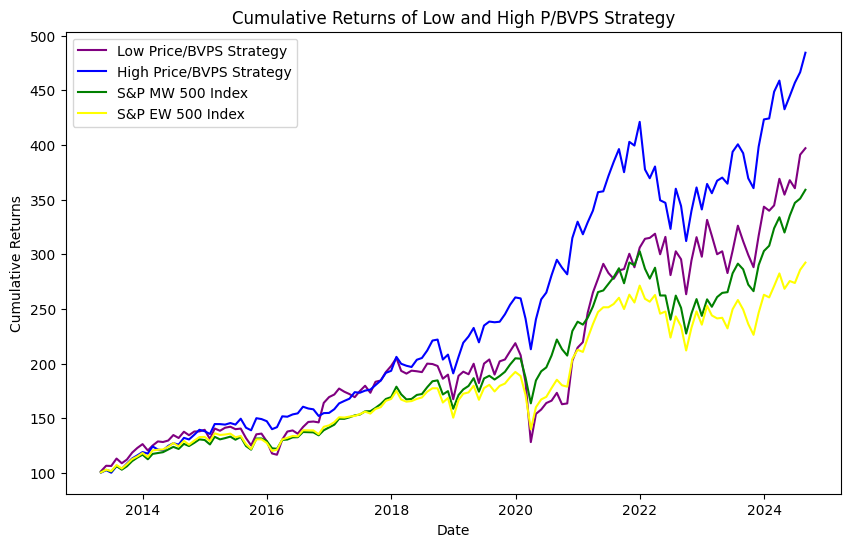

In [221]:
# Visualize the cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
#plt.plot(long_short_pb_cumulative_returns, label='Long-Short Price/BVPS Strategy', color = 'orange')
plt.plot(bottom_20_weighted_cum_returns, label='Low Price/BVPS Strategy', color = 'purple')
plt.plot(top_20_weighted_cum_returns, label='High Price/BVPS Strategy', color = 'blue')
plt.plot(sp500_mw_cum_rets, label='S&P MW 500 Index', color = 'green')
plt.plot(sp500_ew_cum_rets, label='S&P EW 500 Index', color = 'yellow')
plt.title('Cumulative Returns of Low and High P/BVPS Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

## Step 8: Calcualte the relative performance vs. equal-weighted S&P500

In [222]:
low_pb_cumulative_returns_relative = bottom_20_weighted_cum_returns / sp500_ew_cum_rets['Adj Close']
high_pb_cumulative_returns_relative = top_20_weighted_cum_returns / sp500_ew_cum_rets['Adj Close']

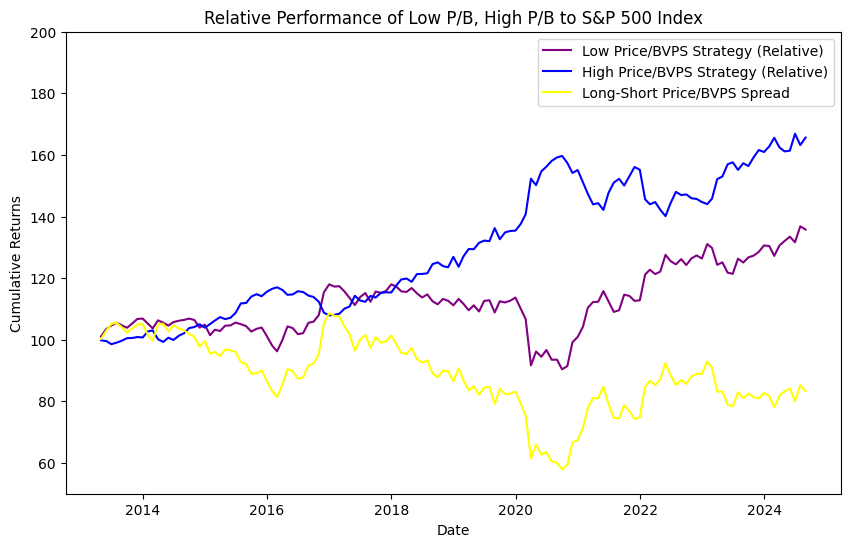

In [223]:
plt.figure(figsize=(10, 6))

plt.plot(low_pb_cumulative_returns_relative*100, label='Low Price/BVPS Strategy (Relative)', color = 'purple')
plt.plot(high_pb_cumulative_returns_relative*100, label='High Price/BVPS Strategy (Relative)', color = 'blue')
plt.plot(long_short_pb_cum_returns, label='Long-Short Price/BVPS Spread', color = 'yellow')
plt.title('Relative Performance of Low P/B, High P/B to S&P 500 Index')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.ylim(50, 200)
# Show the plot with annotations
plt.show()

## Step 9. Analysis of the results

### Step 9.1: Average rolling 12-month returns and volatilities

In [24]:
def calc_rolling_12mon_return_n_vol(monthly_return):
    """
    calculate the rolling 12month returns and volatilities of a given monthly_return series
    """
    rolling_12mon_return = (1 + monthly_return).rolling(window = 12).apply(lambda x: x.prod()) - 1
    rolling_12mon_std = rolling_12mon_return.rolling(window = 12).std()*np.sqrt(12)
    return rolling_12mon_return, rolling_12mon_std

In [157]:
bottom_20_monthly_return = ((bottom_20_df_weights.shift(1) * monthly_returns_df).sum(axis = 1)).iloc[1:]
top_20_monthly_return = ((top_20_df_weights.shift(1) * monthly_returns_df).sum(axis = 1)).iloc[1:]

bottom_20_rolling_12mon_return, bottom_20_rolling_12mon_vol = calc_rolling_12mon_return_n_vol(bottom_20_monthly_return)
top_20_rolling_12mon_return, top_20_rolling_12mon_vol = calc_rolling_12mon_return_n_vol(top_20_monthly_return)

In [26]:
bottom_20_rolling_12mon_return_mean = bottom_20_rolling_12mon_return.mean()
bottom_20_rolling_12mon_vol_mean = bottom_20_rolling_12mon_vol.mean()
top_20_rolling_12mon_return_mean = top_20_rolling_12mon_return.mean()
top_20_rolling_12mon_vol_mean = top_20_rolling_12mon_vol.mean()

In [32]:
def calc_index_monthly_returns(ticker, folder):
    index_price = pd.read_csv(folder + ticker + '.csv', index_col = "Date", parse_dates = True)
    index_price = index_price.resample('ME').last()
    index_monthly_returns = index_price / index_price.shift(1) - 1 
    return index_monthly_returns

In [33]:
mw_index_monthly_return = calc_index_monthly_returns('^GSPC', data_folder_download)
ew_index_monthly_return = calc_index_monthly_returns('^SPXEW', data_folder_download)

In [34]:
mw_index_rolling_12mon_return, mw_index_rolling_12mon_vol = calc_rolling_12mon_return_n_vol(mw_index_monthly_return)
ew_index_rolling_12mon_return, ew_index_rolling_12mon_vol = calc_rolling_12mon_return_n_vol(ew_index_monthly_return)

In [35]:
mw_index_rolling_12mon_return_mean = mw_index_rolling_12mon_return.mean()
mw_index_rolling_12mon_vol_mean = mw_index_rolling_12mon_vol.mean()
ew_index_rolling_12mon_return_mean = ew_index_rolling_12mon_return.mean()
ew_index_rolling_12mon_vol_mean = ew_index_rolling_12mon_vol.mean()

c:\Users\m1852\python\py312\Lib\site-packages\matplotlib\text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
c:\Users\m1852\python\py312\Lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
c:\Users\m1852\python\py312\Lib\site-packages\matplotlib\text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
c:\Users\m1852\python\py312\Lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self

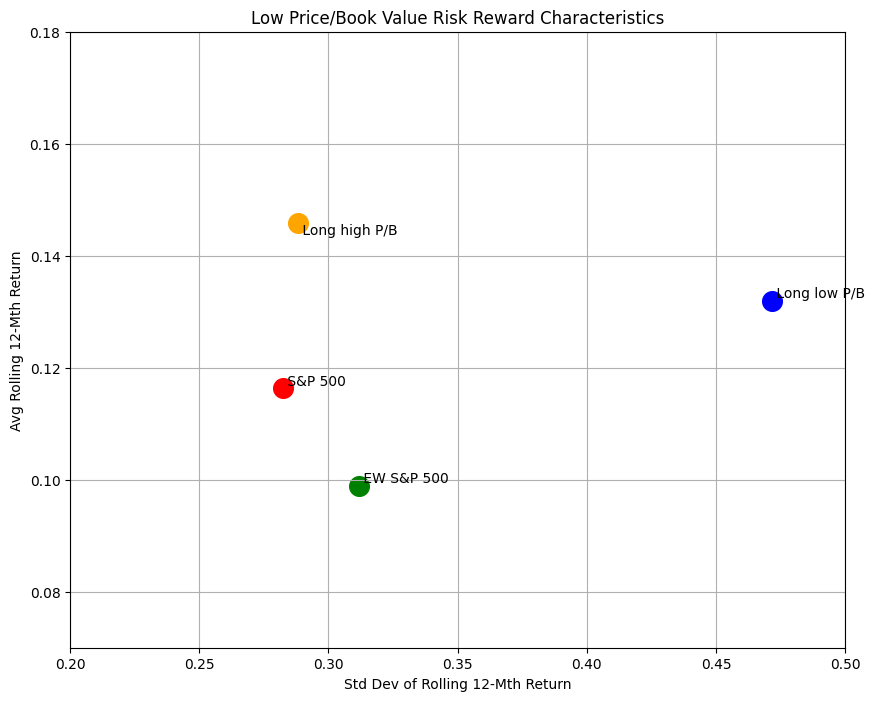

In [38]:
# Data points from the provided images
# Replace these with your actual calculated mean and standard deviation values
returns = {
    'Long low P/B': bottom_20_rolling_12mon_return_mean,
    'Long high P/B': top_20_rolling_12mon_return_mean,
    'EW S&P 500': ew_index_rolling_12mon_return_mean,
    'S&P 500': mw_index_rolling_12mon_return_mean
}

std_devs = {
    'Long low P/B': bottom_20_rolling_12mon_vol_mean,
    'Long high P/B': top_20_rolling_12mon_vol_mean,
    'EW S&P 500': ew_index_rolling_12mon_vol_mean,
    'S&P 500': mw_index_rolling_12mon_vol_mean
}

plt.figure(figsize=(10, 8))

# Plot the points with labels
plt.scatter(bottom_20_rolling_12mon_vol_mean, bottom_20_rolling_12mon_return_mean, color='blue', label='Long low P/B', s=200)
plt.scatter(top_20_rolling_12mon_vol_mean, top_20_rolling_12mon_return_mean, color='orange', label='Long high P/B', s=200)
plt.scatter(ew_index_rolling_12mon_vol_mean, ew_index_rolling_12mon_return_mean, color='green', label='EW S&P 500', s=200)
plt.scatter(mw_index_rolling_12mon_vol_mean, mw_index_rolling_12mon_return_mean, color='red', label='S&P 500', s=200)

# Annotate the points for better labeling
plt.text(bottom_20_rolling_12mon_vol_mean, bottom_20_rolling_12mon_return_mean, ' Long low P/B', verticalalignment='bottom', fontsize=10)
plt.text(top_20_rolling_12mon_vol_mean, top_20_rolling_12mon_return_mean, ' Long high P/B', verticalalignment='top', fontsize=10)
plt.text(ew_index_rolling_12mon_vol_mean, ew_index_rolling_12mon_return_mean, ' EW S&P 500', verticalalignment='bottom', fontsize=10)
plt.text(mw_index_rolling_12mon_vol_mean, mw_index_rolling_12mon_return_mean, ' S&P 500', verticalalignment='bottom', fontsize=10)

# Axis labels and title
plt.xlabel('Std Dev of Rolling 12-Mth Return')
plt.ylabel('Avg Rolling 12-Mth Return')
plt.title('Low Price/Book Value Risk Reward Characteristics')

# Set the custom range for x and y axes
plt.xlim(0.2, 0.50)  # Set the x-axis range (Std Dev)
plt.ylim(0.07, 0.18)  # Set the y-axis range (Avg Rolling Return)

# Add grid and legend
plt.grid(True)

# Show the plot
plt.show()

### Step 9.2. Performance Evaluation

In [67]:
def get_10Y_bond_yields(folder, file, syear, smonth, sday, eyear, emonth, eday): 
    """
    Get the US 10Y government bond yield
    """
    # read the file into a dataframe
    df = pd.read_csv(data_folder_download + file + '.csv', index_col = 'DATE', parse_dates = True).rename(columns = {'DGS10': '10YR'})
    df['10YR'] = pd.to_numeric(df['10YR'], errors = 'coerce')
    df['10YR'] = df['10YR']/100
    # convert datetime
    start = f"{syear}-{smonth}-{sday}"
    start = pd.to_datetime(start) 
    end = f"{eyear}-{emonth}-{eday}"
    end = pd.to_datetime(end)
    # select the timespan
    df = df.loc[start:end]
    return df

In [88]:
US_10Y_bond_rt = get_10Y_bond_yields(data_folder_download, 'DGS10', 2013, 1, 1, 2024, 9, 1)

In [93]:
US_10Y_bond_rt_ME = US_10Y_bond_rt['10YR'].iloc[3:].tolist()

#### 9.2.1 Sharpe Ratio

In [106]:
def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Compute the annualized sharpe ratio of a set of returns
    """
    length = r.shape[0]
    riskfree_rate = pd.Series(riskfree_rate, index = r.index)
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    rf_per_period = rf_per_period.iloc[3:]
    excess_ret = r - rf_per_period
    annualized_ret = (excess_ret + 1).prod() ** (periods_per_year/length) - 1
    annualized_vol = excess_ret.std()*(periods_per_year**0.5)
    
    return annualized_ret/annualized_vol

In [119]:
sharpe_ratio_long_high_pb_strategy = sharpe_ratio(top_20_monthly_return, US_10Y_bond_rt_ME, 12)
sharpe_ratio_long_low_pb_strategy = sharpe_ratio(bottom_20_monthly_return, US_10Y_bond_rt_ME, 12)
print(f'sharpe ratio for long high P/B strategy: {sharpe_ratio_long_high_pb_strategy: .2%}')
print(f'sharpe ratio for long low P/B strategy: {sharpe_ratio_long_low_pb_strategy: .2%}')

sharpe ratio for long high P/B strategy:  77.68%
sharpe ratio for long low P/B strategy:  43.58%


#### 9.2.2 Drawdown

In [41]:
def drawdown(return_series: pd.Series):
    """
       Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

In [118]:
maxDD_long_low_pb_strategy = drawdown(bottom_20_monthly_return)
maxDD_long_high_pb_strategy = drawdown(top_20_monthly_return)
print(f'Max Drawdown for long low P/B strategy: {maxDD_long_low_pb_strategy.Drawdown.min(): .2%}')
print(f'Max Drawdown for long high P/B strategy: {maxDD_long_high_pb_strategy.Drawdown.min(): .2%}')

Max Drawdown for long low P/B strategy: -41.15%
Max Drawdown for long high P/B strategy: -25.82%


#### 9.2.3 Skewness and Kurtosis

In [120]:
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3

def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

In [169]:
skewness_long_low_pb_strategy = skewness(bottom_20_monthly_return)
skewness_long_high_pb_strategy = skewness(top_20_monthly_return)
print(f'skewness for long low P/B strategy: {skewness_long_low_pb_strategy: .2}')
print(f'skewness for long high P/B strategy: {skewness_long_high_pb_strategy: .2}')

kurtosis_long_low_pb_strategy = kurtosis(bottom_20_monthly_return)
kurtosis_long_high_pb_strategy = kurtosis(top_20_monthly_return)
print(f'kurtosis for long low P/B strategy: {kurtosis_long_low_pb_strategy: .2}')
print(f'kurtosis for long high P/B strategy: {kurtosis_long_high_pb_strategy: .2}')

skewness for long low P/B strategy: -0.45
skewness for long high P/B strategy: -0.28
kurtosis for long low P/B strategy:  7.5
kurtosis for long high P/B strategy:  3.4


#### 9.2.4 VaR and CVaR

In [167]:
def var_historic(r, level):
    if isinstance(r, pd.DataFrame):
        # Compute the percentile for each column and then apply abs()
        return r.aggregate(lambda x: abs(np.percentile(x, level)), axis=0)
    elif isinstance(r, pd.Series):
        # Compute the percentile and then apply abs() for a Series
        return abs(np.percentile(r, level))
    else:
        raise TypeError("Expected r to be Series or DataFrame")

In [171]:
historic_var_long_low_pb_strategy = var_historic(bottom_20_monthly_return, 5)
historic_var_long_high_pb_strategy = var_historic(top_20_monthly_return, 5)
print(f'historic var for long low P/B strategy: {historic_var_long_low_pb_strategy: .2%}')
print(f'historic var for long high P/B strategy: {historic_var_long_high_pb_strategy: .2%}')

historic var for long low P/B strategy:  7.10%
historic var for long high P/B strategy:  6.90%


In [162]:
def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        var_value = var_historic(r, level=level)
        is_beyond = r<= -var_value
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level = level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [170]:
cvar_long_low_pb_strategy = cvar_historic(bottom_20_monthly_return, 5)
cvar_long_high_pb_strategy = cvar_historic(top_20_monthly_return, 5)
print(f'cvar for long low P/B strategy: {cvar_long_low_pb_strategy: .2%}')
print(f'cvar for long high P/B strategy: {cvar_long_high_pb_strategy: .2%}')

cvar for long low P/B strategy:  13.22%
cvar for long high P/B strategy:  8.96%


### Step 9.3. Low P/B Factor Sector Concentration

In [246]:
top_20_df_weights = copy.deepcopy(top_20_df_weights)
top_20_df_ind = top_20_df_weights.T

In [253]:
bottom_20_df_weights = copy.deepcopy(bottom_20_df_weights)
bottom_20_df_ind = bottom_20_df_weights.T

In [252]:
# Iterate over the rows (tickers) in top_20_df_ind
def match_sector(df, sp500_df): 
    df = df.astype(object)
    for ticker in df.index:
        # Find the corresponding industry for this ticker from sp500_df
        industry = sp500_df.loc[ticker, 'GICS Sector']
        
        # Replace non-NaN values in top_20_df_ind with the industry name
        df.loc[ticker] = df.loc[ticker].apply(lambda x: industry if not pd.isna(x) else x)

    return df

In [254]:
bottom_20_df_sector = match_sector(bottom_20_df_ind, sp500_df)
top_20_df_sector = match_sector(top_20_df_ind, sp500_df)

In [258]:
bottom_20_df_sector = bottom_20_df_sector.T

In [266]:
gics_sectors = [
    "Energy",
    "Materials",
    "Industrials",
    "Consumer Discretionary",
    "Consumer Staples",
    "Health Care",
    "Financials",
    "Information Technology",
    "Communication Services",
    "Utilities",
    "Real Estate"
]

bottom_20_sector_count = pd.DataFrame(columns = gics_sectors, index = bottom_20_df_sector.index)
for index in bottom_20_sector_count.index.tolist():
    bottom_20_sector_count.loc[index] = bottom_20_df_sector.loc[index].value_counts()

In [267]:
bottom_20_sector_count.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
Date,,,,,,,,,,,
2013-03-31,3.0,2.0,NaN,3.0,1.0,2.0,32.0,3.0,NaN,4.0,1.0
2013-04-30,5.0,3.0,NaN,3.0,1.0,1.0,33.0,4.0,1.0,3.0,1.0
2013-05-31,5,3,1,4,1,1,34,4,1,5,2
2013-06-30,7,3,2,5,1,2,35,4,2,5,2
2013-07-31,7,3,2,5,1,2,34,4,2,6,2


In [268]:
bottom_20_sector_distribution = bottom_20_sector_count.divide(bottom_20_sector_count.sum(axis = 1), axis = 0)

In [269]:
bottom_20_sector_distribution.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
Date,,,,,,,,,,,
2013-03-31,0.058824,0.039216,NaN,0.058824,0.019608,0.039216,0.627451,0.058824,NaN,0.078431,0.019608
2013-04-30,0.090909,0.054545,NaN,0.054545,0.018182,0.018182,0.6,0.072727,0.018182,0.054545,0.018182
2013-05-31,0.081967,0.04918,0.016393,0.065574,0.016393,0.016393,0.557377,0.065574,0.016393,0.081967,0.032787
2013-06-30,0.102941,0.044118,0.029412,0.073529,0.014706,0.029412,0.514706,0.058824,0.029412,0.073529,0.029412
2013-07-31,0.102941,0.044118,0.029412,0.073529,0.014706,0.029412,0.5,0.058824,0.029412,0.088235,0.029412


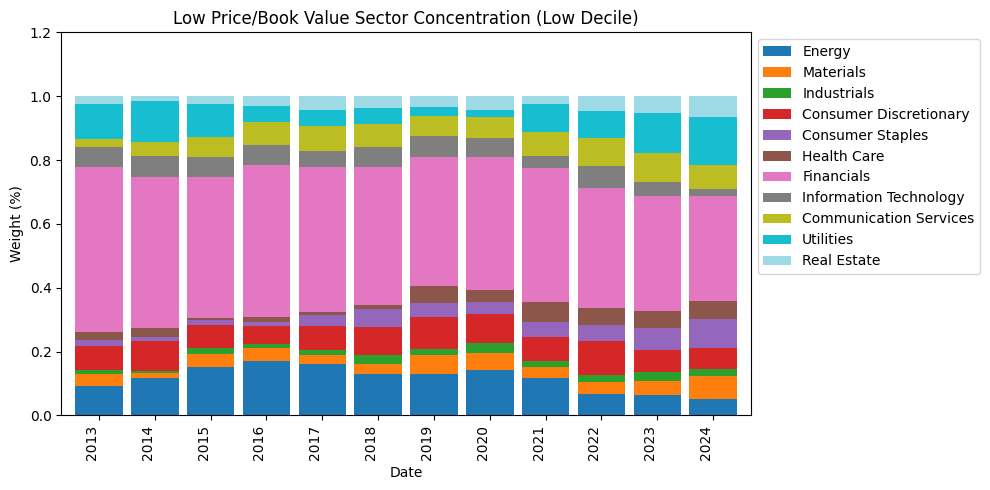

In [276]:
# Replace NaN with 0 for proper plotting
bottom_20_sector_distribution = bottom_20_sector_distribution.fillna(0)


bottom_20_sector_distribution_annual = bottom_20_sector_distribution.resample('Y').mean()
# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each sector as a stack on top of each other
bottom_20_sector_distribution_annual.plot(kind='bar', stacked=True, ax=ax, width=0.85, cmap="tab20")

# Formatting the plot

ax.set_xlabel('Date')
ax.set_ylabel('Weight (%)')
ax.set_title('Low Price/Book Value Sector Concentration (Low Decile)')

# Set the y-axis limits to 120% as per your example
ax.set_ylim(0, 1.2)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha='right')  # Rotate labels for readability
ax.set_xticklabels(bottom_20_sector_distribution_annual.index.year, rotation=90, ha='right')  # Use year labels and rotate

# Add a legend and position it outside the chart
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Display the plot
plt.tight_layout()
plt.show()